In [7]:
# Armaan Kapoor - https://github.com/ak2k2
# IMC Prosperity 2024 - Team Quant NYC
# Members: Armaan Kapoor, Harshil Cherukuri and Shyam Parikh

log_path = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/submissions/2024-04-23_22-21-30.log"

In [8]:
import re
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from scipy.stats import kurtosis, normaltest, skew


def read_file_sections(filepath):
    section_delimiters = ["Sandbox logs:", "Activities log:", "Trade History:"]
    current_section = None
    data = {key: [] for key in section_delimiters}

    with open(filepath, "r") as file:
        for line in file:
            line = line.strip()
            if line in section_delimiters:
                current_section = line
                continue
            if current_section:
                data[current_section].append(line)

    return data


def extract_trades(text):
    # Regex to find all blocks enclosed in curly braces
    trade_pattern = r"\{[^{}]*\}"
    # Regex to extract key-value pairs within curly braces
    kv_pattern = r"\"(\w+)\":\s*(\"[^\"]*\"|\d+)"

    trades = []
    matches = re.findall(trade_pattern, text)
    for match in matches:
        trade_data = {}
        for key, value in re.findall(kv_pattern, match):
            if value.startswith('"') and value.endswith('"'):
                value = value.strip('"')
            else:
                value = int(value)
            trade_data[key] = value
        trades.append(trade_data)
    return trades


sections = read_file_sections(log_path)
activities_data = "\n".join(sections["Activities log:"])
activities_df = pd.read_csv(StringIO(activities_data), delimiter=";")
trade_history_text = "\n".join(sections["Trade History:"])
trades = extract_trades(trade_history_text)
trade_history_df = pd.DataFrame(trades)

In [9]:
r4d1 = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/data_bottles/round-4-island-data-bottle/prices_round_4_day_1.csv"
r4d2 = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/data_bottles/round-4-island-data-bottle/prices_round_4_day_2.csv"
r4d3 = "/Users/armaan/Desktop/imc-prosperity-quant-nyc/data_bottles/round-4-island-data-bottle/prices_round_4_day_3.csv"
activities_df = pd.read_csv(r4d3, sep=";")

In [10]:
df = activities_df[["timestamp", "product", "mid_price", "profit_and_loss"]]

df = df.pivot_table(
    index="timestamp",
    columns="product",
    values=["mid_price", "profit_and_loss"],
    aggfunc="mean",
).reset_index()

df.columns = [
    f"{col[1].lower()}_{col[0]}" if col[1] else col[0] for col in df.columns
]

Option Premium - Intrinsic Value = Time Value + Implied Volatility

In [11]:
df = df[
    [
        "timestamp",
        "coconut_mid_price",
        "coconut_coupon_mid_price",
    ]
]

In [12]:
BASE_ASSET = "coconut_mid_price"

In [13]:
# volume_data = trade_history_df.groupby(['timestamp', 'symbol'])['quantity'].sum().unstack(fill_value=0)
# volume_data.columns = [f"{col.lower()}_volume" for col in volume_data.columns]
# df = df.merge(volume_data, on='timestamp', how='left').fillna(0)


df["MA_SHORT"] = df[BASE_ASSET].rolling(window=20).mean()
df["MA_LONG"] = df[BASE_ASSET].rolling(window=100).mean()


def calculate_rsi(data, window=20):
    """Calculate Relative Strength Index (RSI) for given data."""
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


df["RSI"] = calculate_rsi(df[BASE_ASSET])


# Bollinger Bands
def bollinger_bands(price, window=20, up_std=2.5, low_std=2.4):
    rolling_mean = price.rolling(window=window).mean()
    rolling_std = price.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * up_std)
    lower_band = rolling_mean - (rolling_std * low_std)
    return upper_band, lower_band


df["upper_band"], df["lower_band"] = bollinger_bands(df[BASE_ASSET])


# Calculate the 10th and 90th percentiles using expanding window
df["lower_threshold"] = df[BASE_ASSET].expanding().quantile(0.001)
df["upper_threshold"] = df[BASE_ASSET].expanding().quantile(0.999)


# # Buy Signal Enhanced
# df["Buy_signal"] = (
#     df[BASE_ASSET]
#     < df["lower_band"]  # Undervalued
#     # & (df["RSI"] < 40)  # Oversold
#     # # & (df["MACD"] + 2 > df["MACD_signal"])  # MACD crossover
# )

# # Sell Signal Enhanced
# df["Sell_signal"] = (
#     df[BASE_ASSET]
#     > df["upper_band"]  # Overvalued
#     # & (df["RSI"] > 60)  # Overbought
#     # # & (df["MACD"] - 2 < df["MACD_signal"])  # MACD crossover
# )


In [14]:
df

,timestamp,coconut_mid_price,coconut_coupon_mid_price,MA_SHORT,MA_LONG,RSI,upper_band,lower_band,lower_threshold,upper_threshold
0,0,9991.0,620.0,NaN,NaN,NaN,NaN,NaN,9991.0000,9991.0000
1,100,9990.0,620.5,NaN,NaN,0.000000,NaN,NaN,9990.0010,9990.9990
2,200,9990.5,620.5,NaN,NaN,33.333333,NaN,NaN,9990.0010,9990.9990
3,300,9991.5,621.5,NaN,NaN,60.000000,NaN,NaN,9990.0015,9991.4985
4,400,9990.0,621.5,NaN,NaN,37.500000,NaN,NaN,9990.0000,9991.4980
...,...,...,...,...,...,...,...,...,...,...
9995,999500,9883.5,577.5,9884.775,9884.84,53.333333,9889.207888,9880.519428,9811.5000,9987.5000
9996,999600,9884.5,577.5,9884.875,9884.90,56.250000,9889.106675,9880.812592,9811.5000,9987.5000
9997,999700,9883.5,575.5,9884.875,9884.95,50.000000,9889.106675,9880.812592,9811.5000,9987.5000
9998,999800,9884.0,575.5,9884.900,9885.00,51.515152,9889.087230,9880.880259,9811.5000,9987.5000


count     10000.000000
mean     116383.686063
std       65113.001165
min        2204.158660
25%       67256.795358
50%      112560.318909
75%      153142.881000
max      378087.198611
Name: coconut_divergence, dtype: float64


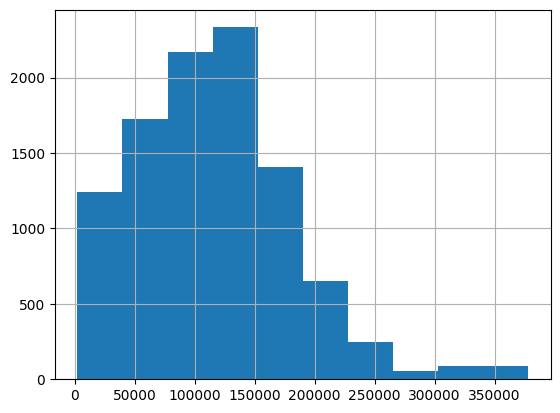

In [15]:
df["coconut_divergence"] = (
    df["coconut_mid_price"]
    * (10000.0 - df["coconut_mid_price"])
    / df["coconut_coupon_mid_price"]
    * (637.63 - df["coconut_coupon_mid_price"])
)


df["coconut_divergence_mean"] = df["coconut_divergence"].expanding().mean()
df["coconut_divergence_std"] = df["coconut_divergence"].expanding().std()

df["coupon_divergence_z_score"] = (
    df["coconut_divergence"] - df["coconut_divergence_mean"]
) / df["coconut_divergence_std"]


# # in current trader
# df["Buy_signal"] = df["coupon_divergence_z_score"] < -0.2
# df["Sell_signal"] = df["coupon_divergence_z_score"] > 2.25

df["Buy_signal"] = df["coconut_divergence"] > df["coconut_divergence"].quantile(0.1)
df["Sell_signal"] = df["coconut_divergence"] < df["coconut_divergence"].quantile(0.9)


df["coconut_divergence"].hist()
print(df["coconut_divergence"].describe())



In [16]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create a subplot layout: 2 rows, 1 column
fig = make_subplots(
    rows=2,
    cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,  # Adjust space between plots
    subplot_titles=(
        f"{BASE_ASSET} Mid Price with Moving Averages",
    ),
)

# Add the main price chart to the first subplot
fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df[BASE_ASSET],
        mode="lines",
        name=f"{BASE_ASSET} Mid Price",
    ),
    row=1,
    col=1,
)

# # Adding moving averages
# fig.add_trace(
#     go.Scatter(
#         x=df["timestamp"],
#         y=df["MA_SHORT"],
#         mode="lines",
#         name="SHORT MA",
#         line=dict(color="blue", dash="dash"),  # Blue dashed line
#     ),
#     row=1,
#     col=1,
# )

# fig.add_trace(
#     go.Scatter(
#         x=df["timestamp"],
#         y=df["MA_LONG"],
#         mode="lines",
#         name="LONG MA",
#         line=dict(color="green", dash="dash"),  # Green dashed line
#     ),
#     row=1,
#     col=1,
# )

fig.add_trace(
    go.Scatter(
        x=df[df["Buy_signal"]]["timestamp"],
        y=df[df["Buy_signal"]][BASE_ASSET],
        mode="markers",
        marker=dict(color="green", size=10, symbol="triangle-up"),
        name="Buy Signal",
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df[df["Sell_signal"]]["timestamp"],
        y=df[df["Sell_signal"]][BASE_ASSET],
        mode="markers",
        marker=dict(color="red", size=10, symbol="triangle-down"),
        name="Sell Signal",
    ),
    row=1,
    col=1,
)

# Adding Bollinger Upper and Lower Bands
fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df["upper_band"],
        mode="lines",
        name="Upper Bollinger Band",
        line=dict(color="magenta", dash="dot"),  # Magenta dotted line for upper band
    ),
    row=1,
    col=1,
)

fig.add_trace(
    go.Scatter(
        x=df["timestamp"],
        y=df["lower_band"],
        mode="lines",
        name="Lower Bollinger Band",
        line=dict(color="magenta", dash="dot"),  # Same style as upper band
    ),
    row=1,
    col=1,
)



# Update layout for better visual alignment and readability
fig.update_layout(
    title=f"{BASE_ASSET} Mid Price with Trading Signals and Premium Spread",
    xaxis_title="Timestamp",
    yaxis_title="Mid Price",
    showlegend=True,
    height=800,  # Adjust the height to accommodate both plots
    font=dict(family="Courier New, monospace", size=14, color="RebeccaPurple"),
)

fig.show()

---

In [17]:
df = df[["timestamp", BASE_ASSET, "Buy_signal", "Sell_signal"]]
df['Signal'] = df['Buy_signal'].astype(int) - df['Sell_signal'].astype(int)

# Initialize the 'Modified_Signal' column
df["Modified_Signal"] = 0
current_signal = 0  # Track the current signal state
holding_signal = False  # This flag checks if we are in a holding state after a signal

for index, row in df.iterrows():
    if row["Signal"] != 0:
        if (
            row["Signal"] == current_signal
        ):  # If the signal is the same as current, continue holding
            df.at[index, "Modified_Signal"] = 0
        else:  # If the signal has changed
            current_signal = row["Signal"]  # Update current signal
            holding_signal = True  # Enable holding state
            df.at[index, "Modified_Signal"] = current_signal
    else:
        if holding_signal:  # If we are holding after a signal
            df.at[index, "Modified_Signal"] = 0
        else:
            df.at[index, "Modified_Signal"] = (
                0  # Continue neutral if no new signal has appeared
            )

    # Reset the holding signal if the current signal is opposite of the last non-zero signal
    if row["Signal"] != 0 and row["Signal"] != current_signal:
        holding_signal = False  # Reset holding state
TRADE_SIZE = 300
df['signed_quantity'] = df['Modified_Signal'] * TRADE_SIZE
df['cum_qty'] = df['signed_quantity'].cumsum()
df['cash_value'] = (-df['coconut_mid_price'] * df['signed_quantity']).cumsum()
final_cash_value = df.iloc[-1]['cash_value']
final_qty = df.iloc[-1]['cum_qty']
liq_val = df.iloc[-1]['coconut_mid_price']
net_pnl = final_cash_value + (final_qty * liq_val)
print(f"Net P&L = {net_pnl}")

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_37911/703952680.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_37911/703952680.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Net P&L = 38700.0


/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_37911/703952680.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_37911/703952680.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/nx/n1nd7k552014npzf4p5zpxh00000gn/T/ipykernel_37911/703952680.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d